In [1]:
import json
import os
import time

import mambapy
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import torch
from mambapy.mamba import Mamba, MambaConfig
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

from utils.experiments import ParamGrid

Mamba(
  (layers): ModuleList(
    (0-1): 2 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=16, out_features=64, bias=False)
        (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
        (x_proj): Linear(in_features=32, out_features=33, bias=False)
        (dt_proj): Linear(in_features=1, out_features=32, bias=True)
        (out_proj): Linear(in_features=32, out_features=16, bias=False)
      )
      (norm): RMSNorm()
    )
  )
)

ResidualBlock(
  (mixer): MambaBlock(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (x_proj): Linear(in_features=32, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=32, bias=True)
    (out_proj): Linear(in_features=32, out_features=16, bias=False)
  )
  (norm): RMSNorm()
)

In [ ]:
rb = mambapy.mamba.ResidualBlock(config)
rb

torch.Size([10, 8, 16])

In [52]:
test_x = torch.as_tensor(np.random.random((10, 8, 16)), dtype=torch.float32)
rb(test_x).shape

torch.Size([10, 8, 16])

In [53]:
mamba(test_x).shape

['0', '1', '4', '6', '9', '10', 'scales.json']

In [7]:
test_data = pd.read_csv('neuro/data/v5/0/data.csv', index_col=0)
test_data.head()

,timestamps,k_inf,heat,U235,U238
0,0.0,1.234272,0.000199,2.797238e+23,5.243891e+24
1,21600.0,1.244806,60.910299,2.797229e+23,5.243891e+24
2,43200.0,1.238295,62.401145,2.797221e+23,5.243890e+24
3,64800.0,1.231683,63.195829,2.797213e+23,5.243890e+24
4,86400.0,1.236505,63.737268,2.797205e+23,5.243889e+24


,timestamps,k_inf,heat,U235,U238
count,1.201000e+03,1201.000000,1201.000000,1.201000e+03,1.201000e+03
mean,1.296000e+07,1.233796,68.424573,2.792299e+23,5.243605e+24
std,7.491812e+06,0.003590,2.099193,2.852808e+20,1.653372e+20
min,0.000000e+00,1.221775,0.000199,2.787367e+23,5.243319e+24
25%,6.480000e+06,1.231389,68.358239,2.789831e+23,5.243462e+24
50%,1.296000e+07,1.233843,68.715078,2.792297e+23,5.243605e+24
75%,1.944000e+07,1.236174,68.878027,2.794766e+23,5.243748e+24
max,2.592000e+07,1.244806,69.002666,2.797238e+23,5.243891e+24


In [9]:
def normalize(df: pd.DataFrame):
    # tsp = list(df.timestamps.values[1:] - df.timestamps.values[:-1])
    # tsp.append(tsp[-1])
    # df['timestamps'] = tsp
    df['timestamps'] /=3600*24*300
    df['k_inf'] -= 1
    # print(savgol_filter(df['k_inf'], 7, 4).shape, df['k_inf'].shape)
    # kinf0 = df['k_inf'].values[2:]
    # kinf1 = df['k_inf'].values[1:-1]
    # kinf2 = df['k_inf'].values[:-2]
    # kinf = list((kinf0+kinf1+kinf2)/3)
    # kinf.append(kinf2[0])
    # kinf.append(kinf0[-1])
    df['k_inf'] = savgol_filter(df['k_inf'], 25, 3)
    
    # u5 = df['U235'].values[1:]- df['U235'].values[:-1]
    # u5= list(u5)
    # u5.append(u5[-1])
    # u8 = df['U238'].values[1:]- df['U238'].values[:-1]
    # u8= list(u8)
    # u8.append(u8[-1])
    # df['heat'] /= 2100
    # df['U235'] = u5
    # df['U238'] = u8
    return df

,timestamps,k_inf,heat,U235,U238
count,1201.000000,1201.000000,1201.000000,1.201000e+03,1.201000e+03
mean,0.500000,0.233797,68.424573,2.792299e+23,5.243605e+24
std,0.289036,0.001462,2.099193,2.852808e+20,1.653372e+20
min,0.000000,0.229257,0.000199,2.787367e+23,5.243319e+24
25%,0.250000,0.232716,68.358239,2.789831e+23,5.243462e+24
50%,0.500000,0.233793,68.715078,2.792297e+23,5.243605e+24
75%,0.750000,0.234868,68.878027,2.794766e+23,5.243748e+24
max,1.000000,0.237776,69.002666,2.797238e+23,5.243891e+24


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

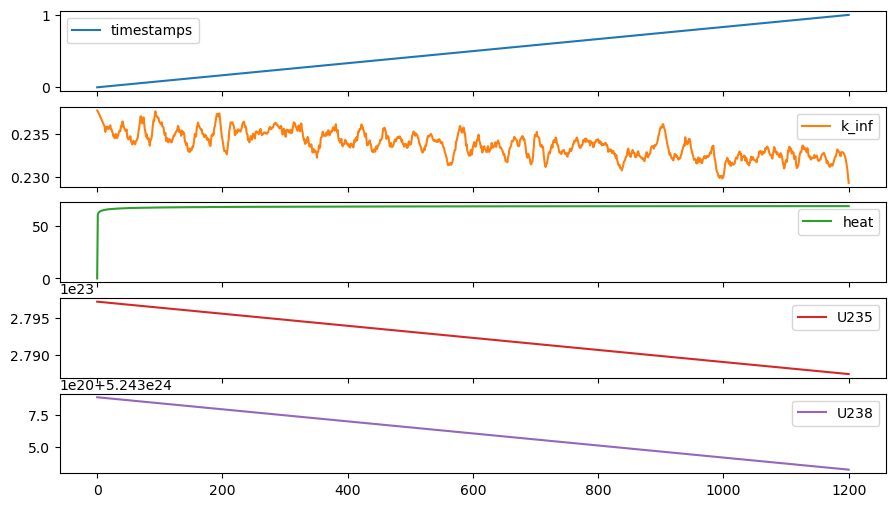

In [11]:
test_data_normed.plot(subplots=True, figsize=(16/3*2, 9/3*2))

<Axes: >

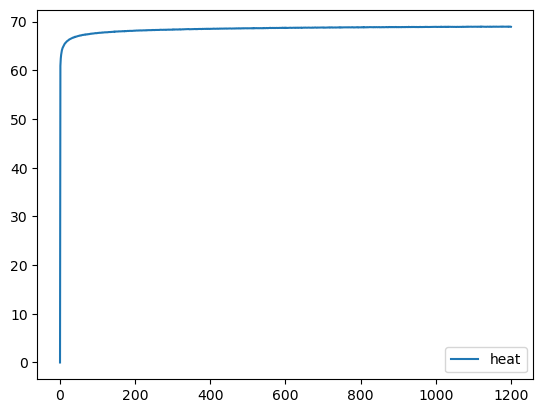

In [13]:
neuro_data_path = 'neuro/data/v5'

NotADirectoryError: [Errno 20] Not a directory: 'neuro/data/v5/scales.json/data.csv'

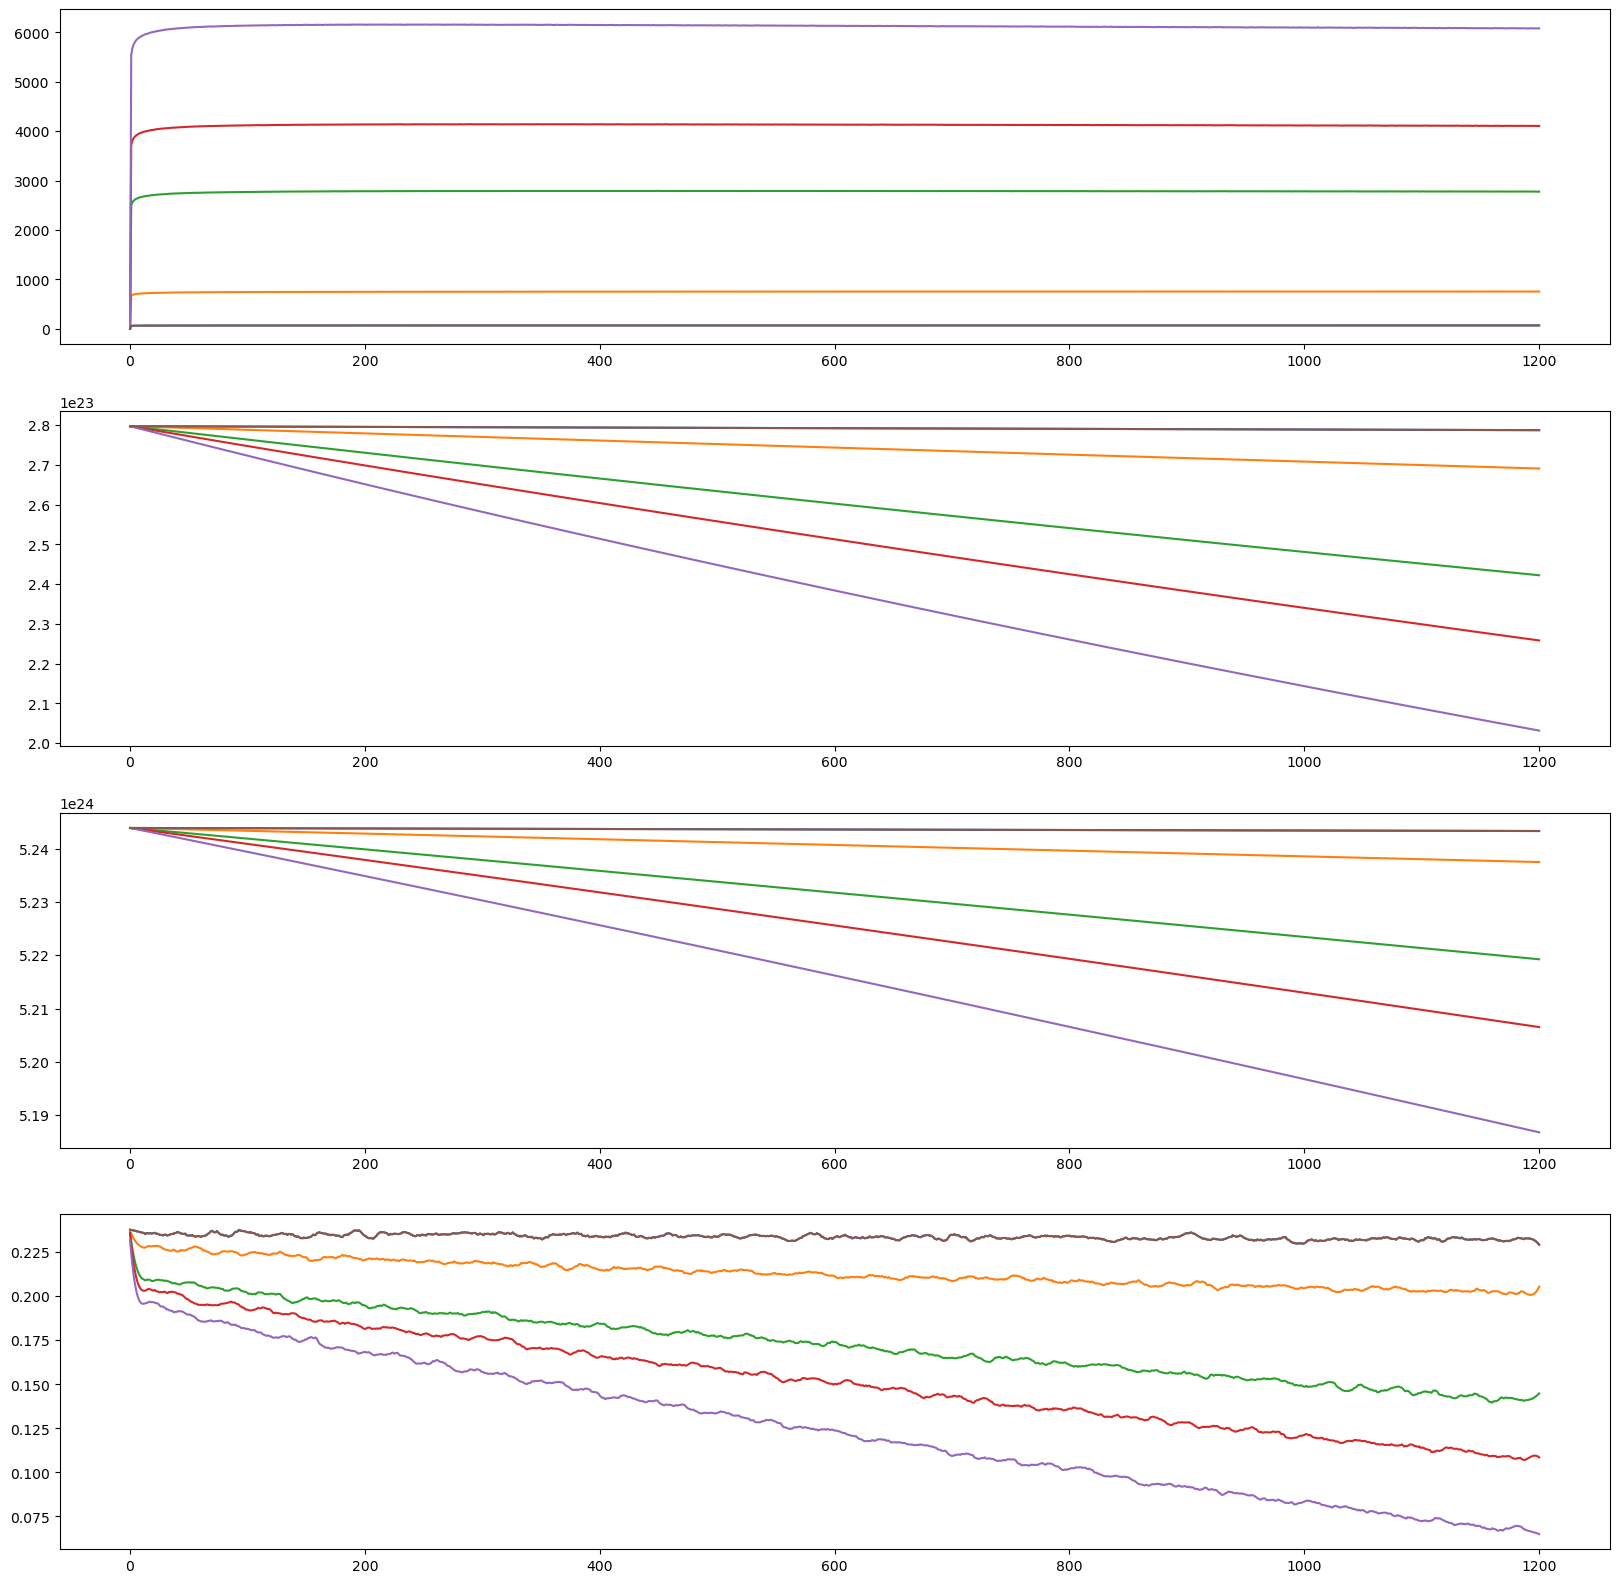

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
for i in range(len(os.listdir(neuro_data_path))):
    df_path = os.listdir(neuro_data_path)[i]
    df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
    df = normalize(df)
    ax[0].plot(df['heat'])
    ax[1].plot(df['U235'])
    # ax[1].set_ylim([0.9,0.91])
    ax[2].plot(df['U238'])
    ax[3].plot(df['k_inf'])


In [15]:
dataset, contexts = [], []
for i in tqdm(range(len(os.listdir(neuro_data_path)))):
    try:
        df_path = os.listdir(neuro_data_path)[i]
        df = pd.read_csv(os.path.join(neuro_data_path, df_path, 'data.csv'), index_col=0)
        df = normalize(df)
        cts = json.load(open(os.path.join(neuro_data_path, df_path, 'context.json')))
        dataset.append(df.values)
        contexts.append(cts)
    except Exception as e:
        print(e)
print(dataset)
dataset = np.array(dataset[:-1])
dataset.shape, len(contexts)

100%|██████████| 7/7 [00:00<00:00, 487.10it/s]

[Errno 20] Not a directory: 'neuro/data/v5/scales.json/data.csv'
[array([[0.00000000e+00, 2.37775806e-01, 1.98968893e-04, 2.79723754e+23,
        5.24389124e+24],
       [8.33333333e-04, 2.37655067e-01, 6.09102992e+01, 2.79722929e+23,
        5.24389077e+24],
       [1.66666667e-03, 2.37518550e-01, 6.24011454e+01, 2.79722104e+23,
        5.24389030e+24],
       ...,
       [9.98333333e-01, 2.30724719e-01, 6.89480505e+01, 2.78738387e+23,
        5.24332019e+24],
       [9.99166667e-01, 2.30050984e-01, 6.89684628e+01, 2.78737567e+23,
        5.24331971e+24],
       [1.00000000e+00, 2.29257335e-01, 6.89422985e+01, 2.78736746e+23,
        5.24331924e+24]], shape=(1201, 5)), array([[0.00000000e+00, 2.37032100e-01, 1.98968893e-04, 2.79723754e+23,
        5.24389124e+24],
       [8.33333333e-04, 2.35492417e-01, 6.69990958e+02, 2.79714684e+23,
        5.24388602e+24],
       [1.66666667e-03, 2.34110252e-01, 6.86642117e+02, 2.79705621e+23,
        5.24388076e+24],
       ...,
       [9.98333333

((5, 1201, 5), 6)

In [16]:
scales = {
    'timestamps': {'min': 0, 'max':1},
    'k_inf': {
        'min': 0,
        'max': 1
    },

}
for col, _min, _max in zip(df.columns, dataset.min(axis=(0, 1)), dataset.max(axis=(0, 1))):
    if col in scales:
        continue
    scales[col] = {
        'min': _min,
        'max': _max
    }
json.dump(scales, open(os.path.join(neuro_data_path, 'scales.json'), 'w'))
scales

{'timestamps': {'min': 0, 'max': 1},
 'k_inf': {'min': 0, 'max': 1},
 'heat': {'min': np.float64(0.000198968892758),
  'max': np.float64(6157.654022584871)},
 'U235': {'min': np.float64(2.031645192037719e+23),
  'max': np.float64(2.79723753587736e+23)},
 'U238': {'min': np.float64(5.186761254305729e+24),
  'max': np.float64(5.243891244223711e+24)}}

(array([0.00000000e+00, 6.49481643e-02, 1.98968893e-04, 2.03164519e+23,
        5.18676125e+24]),
 array([1.00000000e+00, 2.37775806e-01, 6.15765402e+03, 2.79723754e+23,
        5.24389124e+24]))

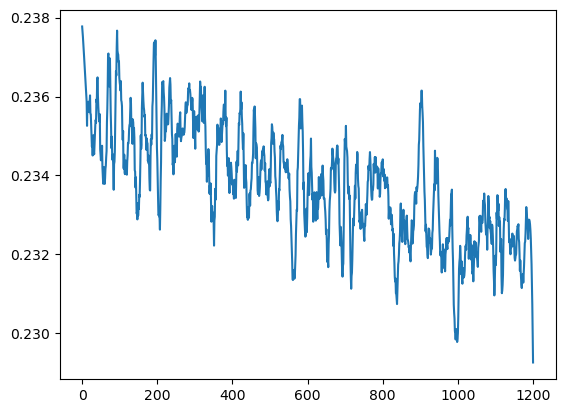

In [18]:
mins, maxs = [], []
for key, value in scales.items():
    mins.append(value['min'])
    maxs.append(value['max'])
mins = np.array(mins)
maxs = np.array(maxs)

scaled = ((dataset - mins) / (maxs - mins))
plt.plot(scaled[0, :, 1])

(array([1.00000000e+00, 2.37775806e-01, 6.15765402e+03, 2.79723754e+23,
        5.24389124e+24]),
 array([0.00000000e+00, 6.49481643e-02, 1.98968893e-04, 2.03164519e+23,
        5.18676125e+24]))

(array([0.00000000e+00, 0.00000000e+00, 1.98968893e-04, 2.03164519e+23,
        5.18676125e+24]),
 array([1.00000000e+00, 1.00000000e+00, 6.15765402e+03, 2.79723754e+23,
        5.24389124e+24]))

array([[0.23777581, 0.        , 1.        , 1.        ],
       [0.23765507, 0.00989177, 0.99998923, 0.99999169],
       [0.23751855, 0.01013388, 0.99997846, 0.99998339],
       ...,
       [0.23072472, 0.0111971 , 0.98712936, 0.9900043 ],
       [0.23005098, 0.01120041, 0.98711865, 0.98999594],
       [0.22925733, 0.01119616, 0.98710792, 0.98998764]], shape=(1201, 4))

[{'enr': 3.0,
  'power': 1000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 11000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 41000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 61000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 91000,
  'water_

In [23]:
class MambaDataset(torch.utils.data.Dataset):

    def __init__(self, data: np.array, context: dict, window_size=16):
        self.data = data
        self.context = context
        self.window_size = window_size

    def __len__(self):
        return self.data.shape[0] - self.window_size + 1

    def __getitem__(self, idx):
        assert idx < len(self), f'idx {idx} out of range'
        _from = max(0, idx - self.window_size)
        window = self.data[_from:idx, :]
        if window.shape[0] < self.window_size:
            zeros = np.zeros((self.window_size - window.shape[0], self.data.shape[1]))
            window = np.vstack((zeros, window))
        pred = self.data[idx:idx + self.window_size, :]
        return window.T, pred.T

In [24]:
scaled.shape

(5, 1201, 5)

In [25]:
test_dataset = MambaDataset(scaled[0, ...], contexts[0], window_size=8)
test_dataset.data.min(axis=(0))

array([0.        , 0.22925733, 0.        , 0.98710792, 0.98998764])

[{'enr': 3.0,
  'power': 1000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 11000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 41000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 61000,
  'water_volume': 155.4871681372756,
  'water_density': 1.0,
  'fuel_volume': 298.45130209103024,
  'fuel_density': 8.3,
  'fuel_id': '2',
  'cladding_volume': 537.2123437638545,
  'cladding_density': 6.56},
 {'enr': 3.0,
  'power': 91000,
  'water_

In [27]:
dataset.shape

(5, 1201, 5)

In [28]:
dataset1 = (scaled[:,1:,:]-scaled[:,:-1,:])
divs = scaled[:,:-1,:]
divs[divs==0]=1
dataset1 /= divs
dataset1 = np.concat([scaled[:,0:1,:], dataset1], axis=1)
dataset1[:,0,:]

array([[1.        , 0.23777581, 1.        , 1.        , 1.        ],
       [1.        , 0.2370321 , 1.        , 1.        , 1.        ],
       [1.        , 0.23617199, 1.        , 1.        , 1.        ],
       [1.        , 0.23568767, 1.        , 1.        , 1.        ],
       [1.        , 0.23188809, 1.        , 1.        , 1.        ]])

In [30]:
class MyMamba(Mamba):
    train_time = 0

    def __init__(self, config: mambapy.mamba.MambaConfig = None):
        if config is None:
            config = mambapy.mamba.MambaConfig(d_model=8, n_layers=5)
        super().__init__(config)
        self.context_emdedding = torch.nn.Conv1d(1, config.d_model, 1)
        self.context_norm = torch.nn.LayerNorm(config.d_model)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def _reformat_context(self, context):
        _context = (
            context['enr'],
            context['water_volume'],
            context['fuel_volume'],
            context['cladding_volume'],
            context['power']
        )
        _context = torch.as_tensor(np.array(_context)[np.newaxis, :], dtype=torch.float32)
        return _context

    def set_context(self, context: dict):
        self.context = self._reformat_context(context).to(self.device)
        self.cx = self.context_emdedding(self.context).T
        self.cx = self.context_norm(self.cx).mean(dim=0)

    def forward(self, x, context=None):
        if context is None:
            cx = self.cx
        else:
            cx = self.context_emdedding(context).T
            cx = self.context_norm(cx).mean(dim=0)
        x = torch.as_tensor(x, dtype=torch.float32)
        for layer in self.layers:
            x = x + cx
            x = layer(x)
        return x
    
    def _calc_loss(self, true, pred):
        loss_fn = torch.nn.MSELoss(reduction='none')
        loss = (loss_fn(pred, true).mean(dim=1)*(2-true[:,0,:])).mean()
        return loss
        

    def fit(self, data_dicts: list, epochs: int, batch_size: int = 10, savedir='neuro/models'):
        os.makedirs(savedir, exist_ok=True)
        start_train_time = time.perf_counter()
        
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        hist = []
        
        pbar = trange(epochs, desc='Training started...', leave=False)
        for epoch in pbar:
            start = time.perf_counter()
            epoch_loss = []

            pbar.set_description(f'Epoch {epoch}/{epochs}:')
            pbar.refresh()
            optimizer.zero_grad()
            for data_dict in data_dicts:
                context = data_dict['context']
                ds = MambaDataset(data_dict['data'], context, window_size=self.config.d_model)
                self.set_context(data_dict['context'])
                dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)
                for x, y in dl:
                    x = torch.as_tensor(x, dtype=torch.float32).to(self.device)
                    y = torch.as_tensor(y, dtype=torch.float32).to(self.device)
                    outputs = self(x, self.context)
                    # Compute the loss and its gradients
                    loss = self._calc_loss(y, outputs)
                    loss.backward()
                    # Adjust learning weights
                    optimizer.step()
                    epoch_loss.append(loss.item())
                    if not hasattr(self, 'best_loss') or loss.item() < self.best_loss:
                        self.best_loss = loss.item()
                        torch.save(self.state_dict(), os.path.join(savedir, 'best.pt'))

            epoch_loss = sum(epoch_loss) / len(epoch_loss)
            pbar.set_postfix_str(f'Loss: {epoch_loss:.4f}. Took {(time.perf_counter() - start) / 60:.2f} minutes')
            hist.append(epoch_loss)

        print(f'Training finished. Best Loss: {self.best_loss}')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
        ax.plot(hist)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Loss Curve\nBest Loss: {self.best_loss:.4f}')
        ax.grid()
        delattr(self, 'best_loss')
        plt.savefig(os.path.join(savedir, 'loss.png'))
        torch.save(self.state_dict(), os.path.join(savedir, 'last.pt'))
        self.train_time = time.perf_counter() - start_train_time
        return hist

    def test(self, data, context, savedir='neuro/models'):
        test_dataset = MambaDataset(data, context, window_size=self.config.d_model)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
        self.set_context(context)

        true, pred = [], []
        for x, y in test_data_loader:
            x = torch.as_tensor(x, dtype=torch.float32).to(mmb.device)
            y = torch.as_tensor(y, dtype=torch.float32).to(mmb.device)
            true.append(y.cpu().numpy()[0, :, 0])
            pred.append(mmb(x).cpu().detach().numpy()[0, :, 0])
        true = np.array(true)
        pred = np.array(pred)

        fig, ax = plt.subplots(nrows=true.shape[-1], ncols=1, figsize=(20, 20))
        for i in range(len(ax)):
            ax[i].plot(true[:, i], label='true')
            ax[i].plot(pred[:, i], label='pred')
            ax[i].legend()
            ax[i].grid()
        plt.savefig(os.path.join(savedir, 'testing.jpeg'))
        dif = abs((true[:, 3:] - pred[:, 3:]) / true[:, 3:])
        mean_dif  = dif.mean()
        max_dif = dif.max()
        with open(os.path.join(savedir, 'testing_results.json'), 'w') as f:
            json.dump({
                'training_time': int(self.train_time),
                'testing_results': {
                    "mean_dif": float(mean_dif),
                    "max_dif": float(max_dif)
                }
            }, f)
        print(f'Testing finished. Error: {mean_dif*100:.4}%')

In [31]:
prepared_data = [{'data': dataset1[i], 'context': contexts[i]} for i in range(1, len(contexts)-1)]

In [32]:
dataset1[0]

array([[ 1.00000000e+00,  2.37775806e-01,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [ 8.33333333e-04, -5.07788033e-04,  9.89177079e-03,
        -1.07692161e-05, -8.30752016e-06],
       [ 1.00000000e+00, -5.74430634e-04,  2.44761736e-02,
        -1.07721352e-05, -8.29863864e-06],
       ...,
       [ 8.35421888e-04, -2.43334039e-03, -2.43014021e-04,
        -1.08739655e-05, -8.38855018e-06],
       [ 8.34724541e-04, -2.92008035e-03,  2.96054703e-04,
        -1.08535359e-05, -8.44569072e-06],
       [ 8.34028357e-04, -3.44988541e-03, -3.79366781e-04,
        -1.08684023e-05, -8.38915223e-06]], shape=(1201, 5))

dict_keys(['d_model', 'n_layers']) <itertools.product object at 0x70aebdef3600>


Training finished. Best Loss: 0.0038364208303391933
Testing finished. Error: 6.271e+05%


Training finished. Best Loss: 0.032461196184158325
Testing finished. Error: 8.172e+05%


Training finished. Best Loss: 0.0027736499905586243
Testing finished. Error: 5.952e+05%


Training finished. Best Loss: 0.00703086145222187
Testing finished. Error: 1.755e+05%


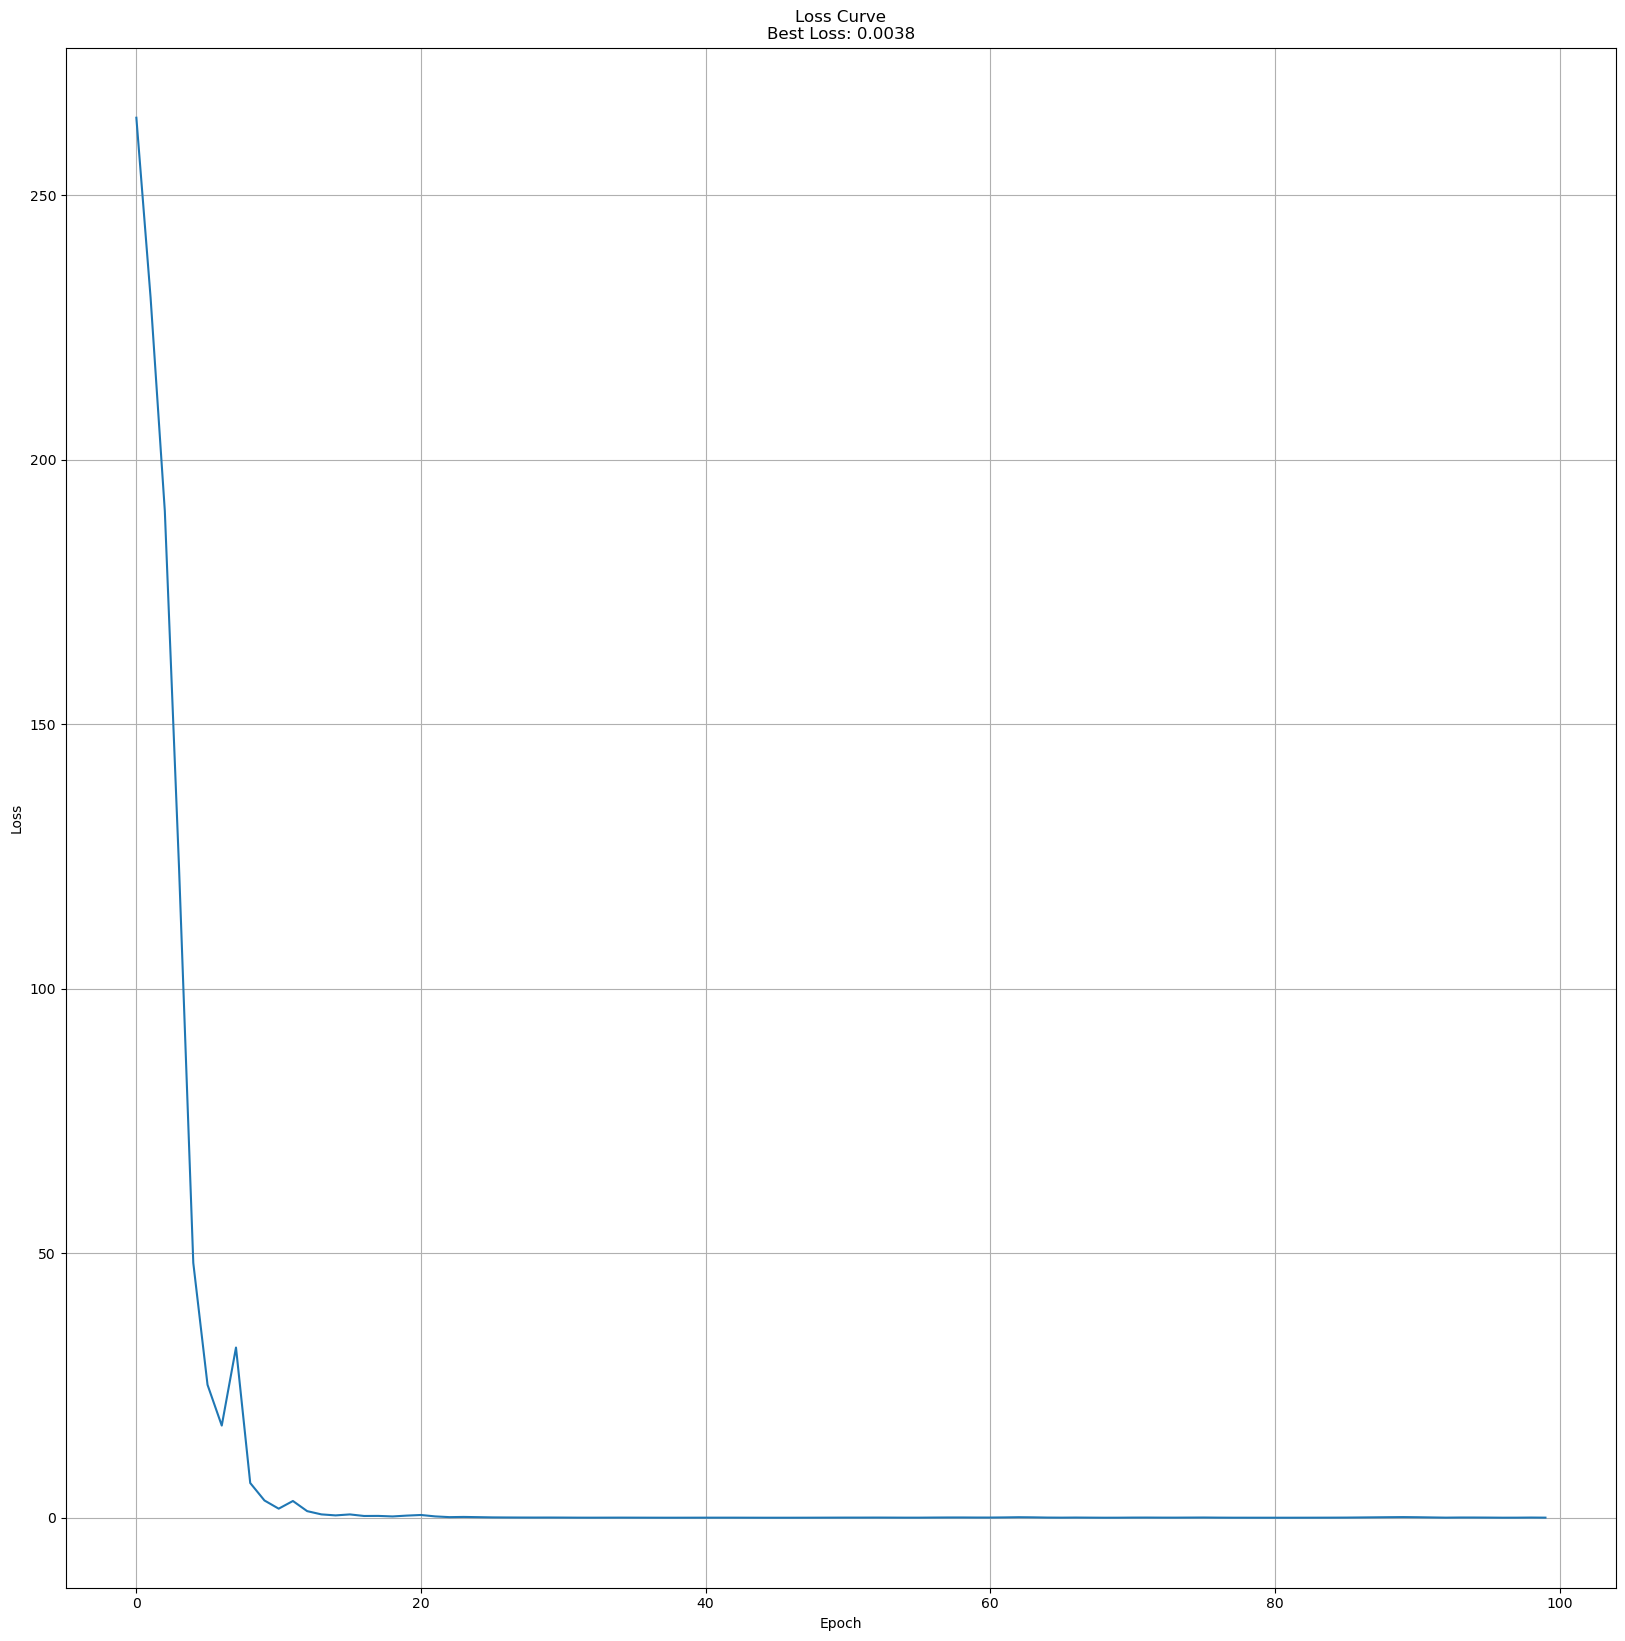

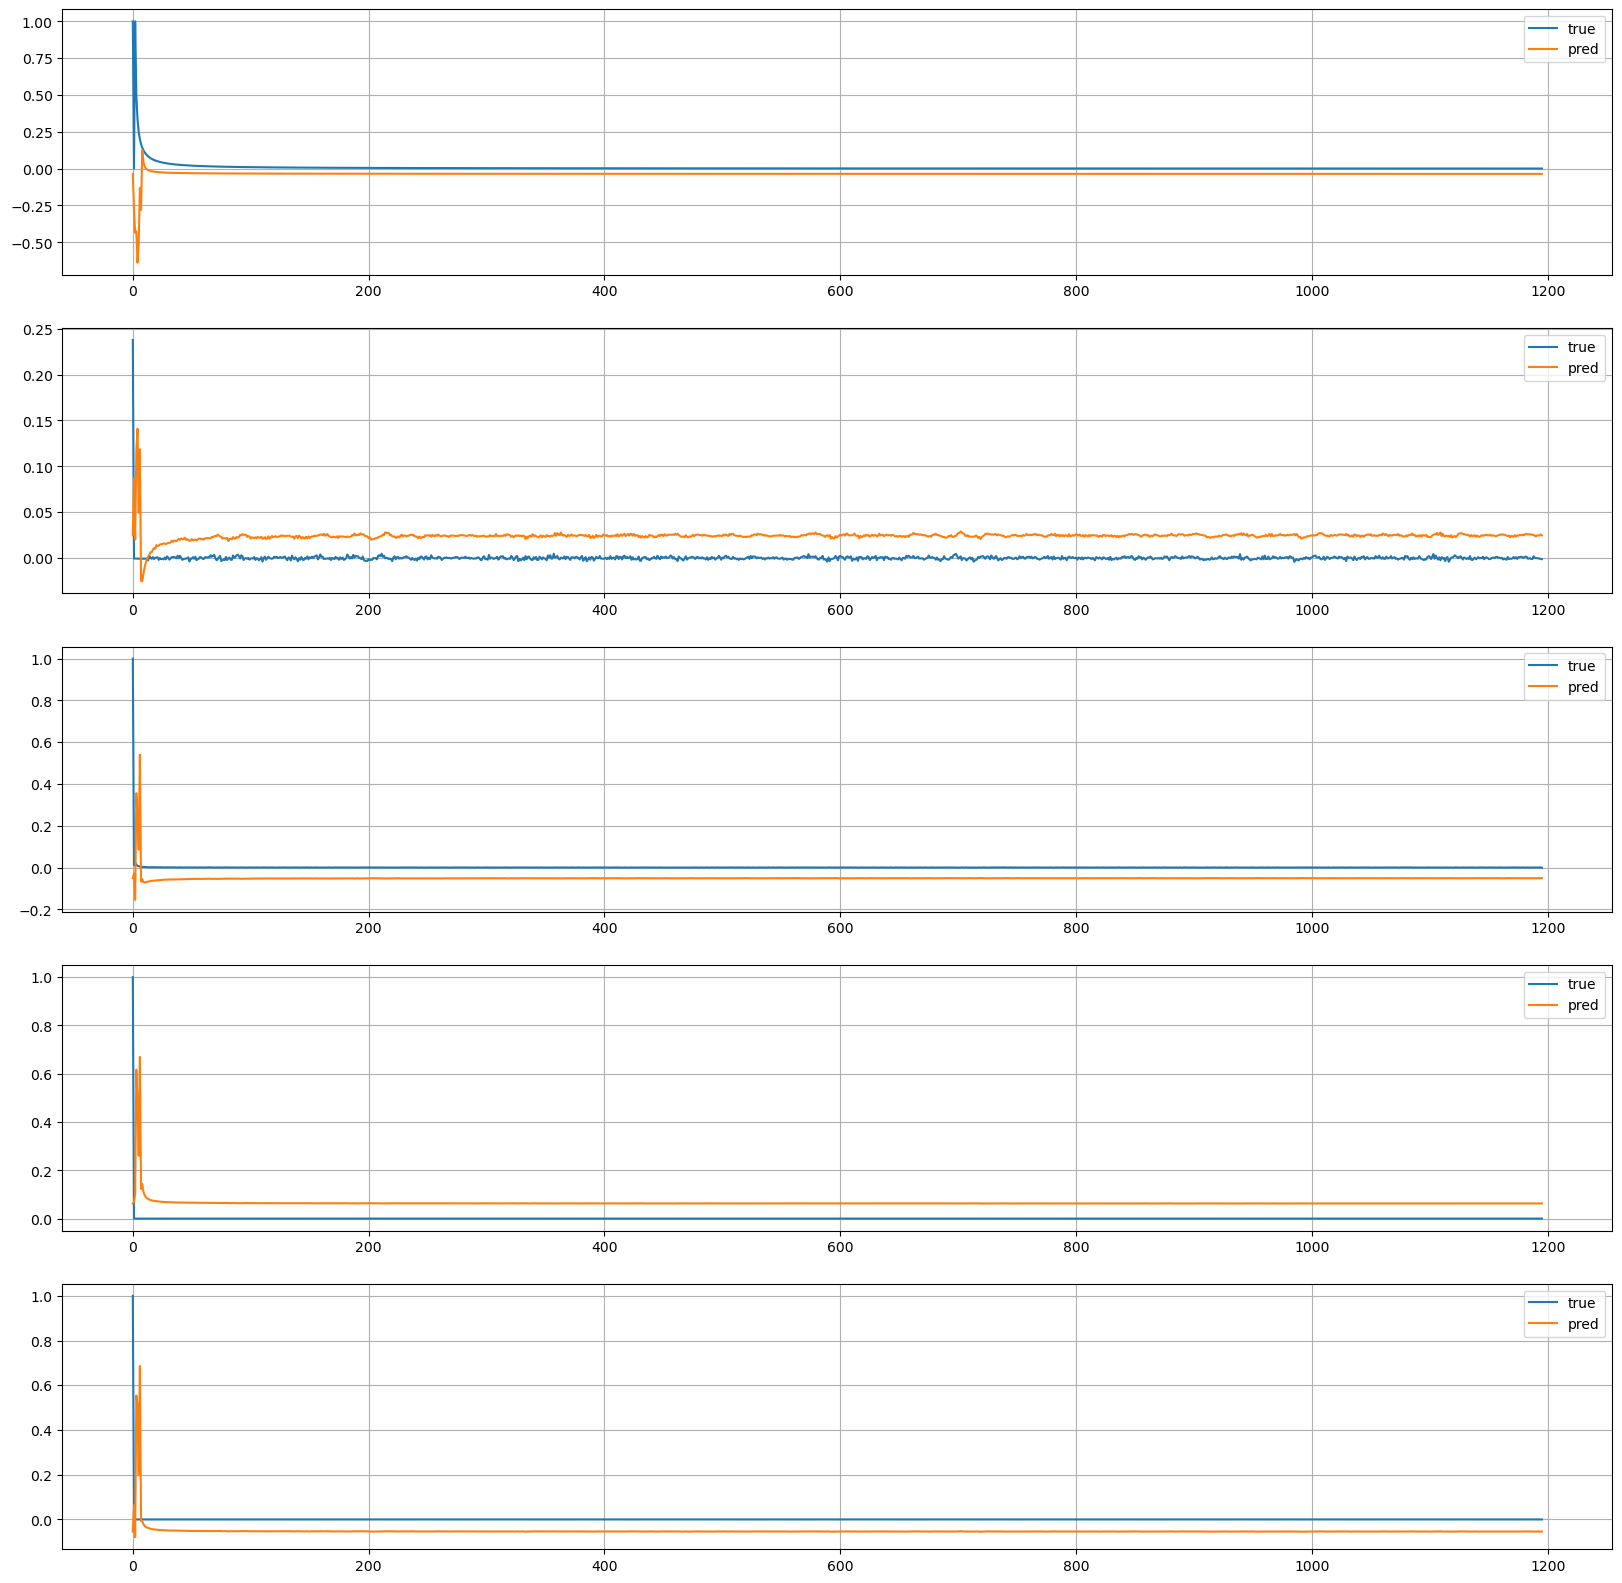

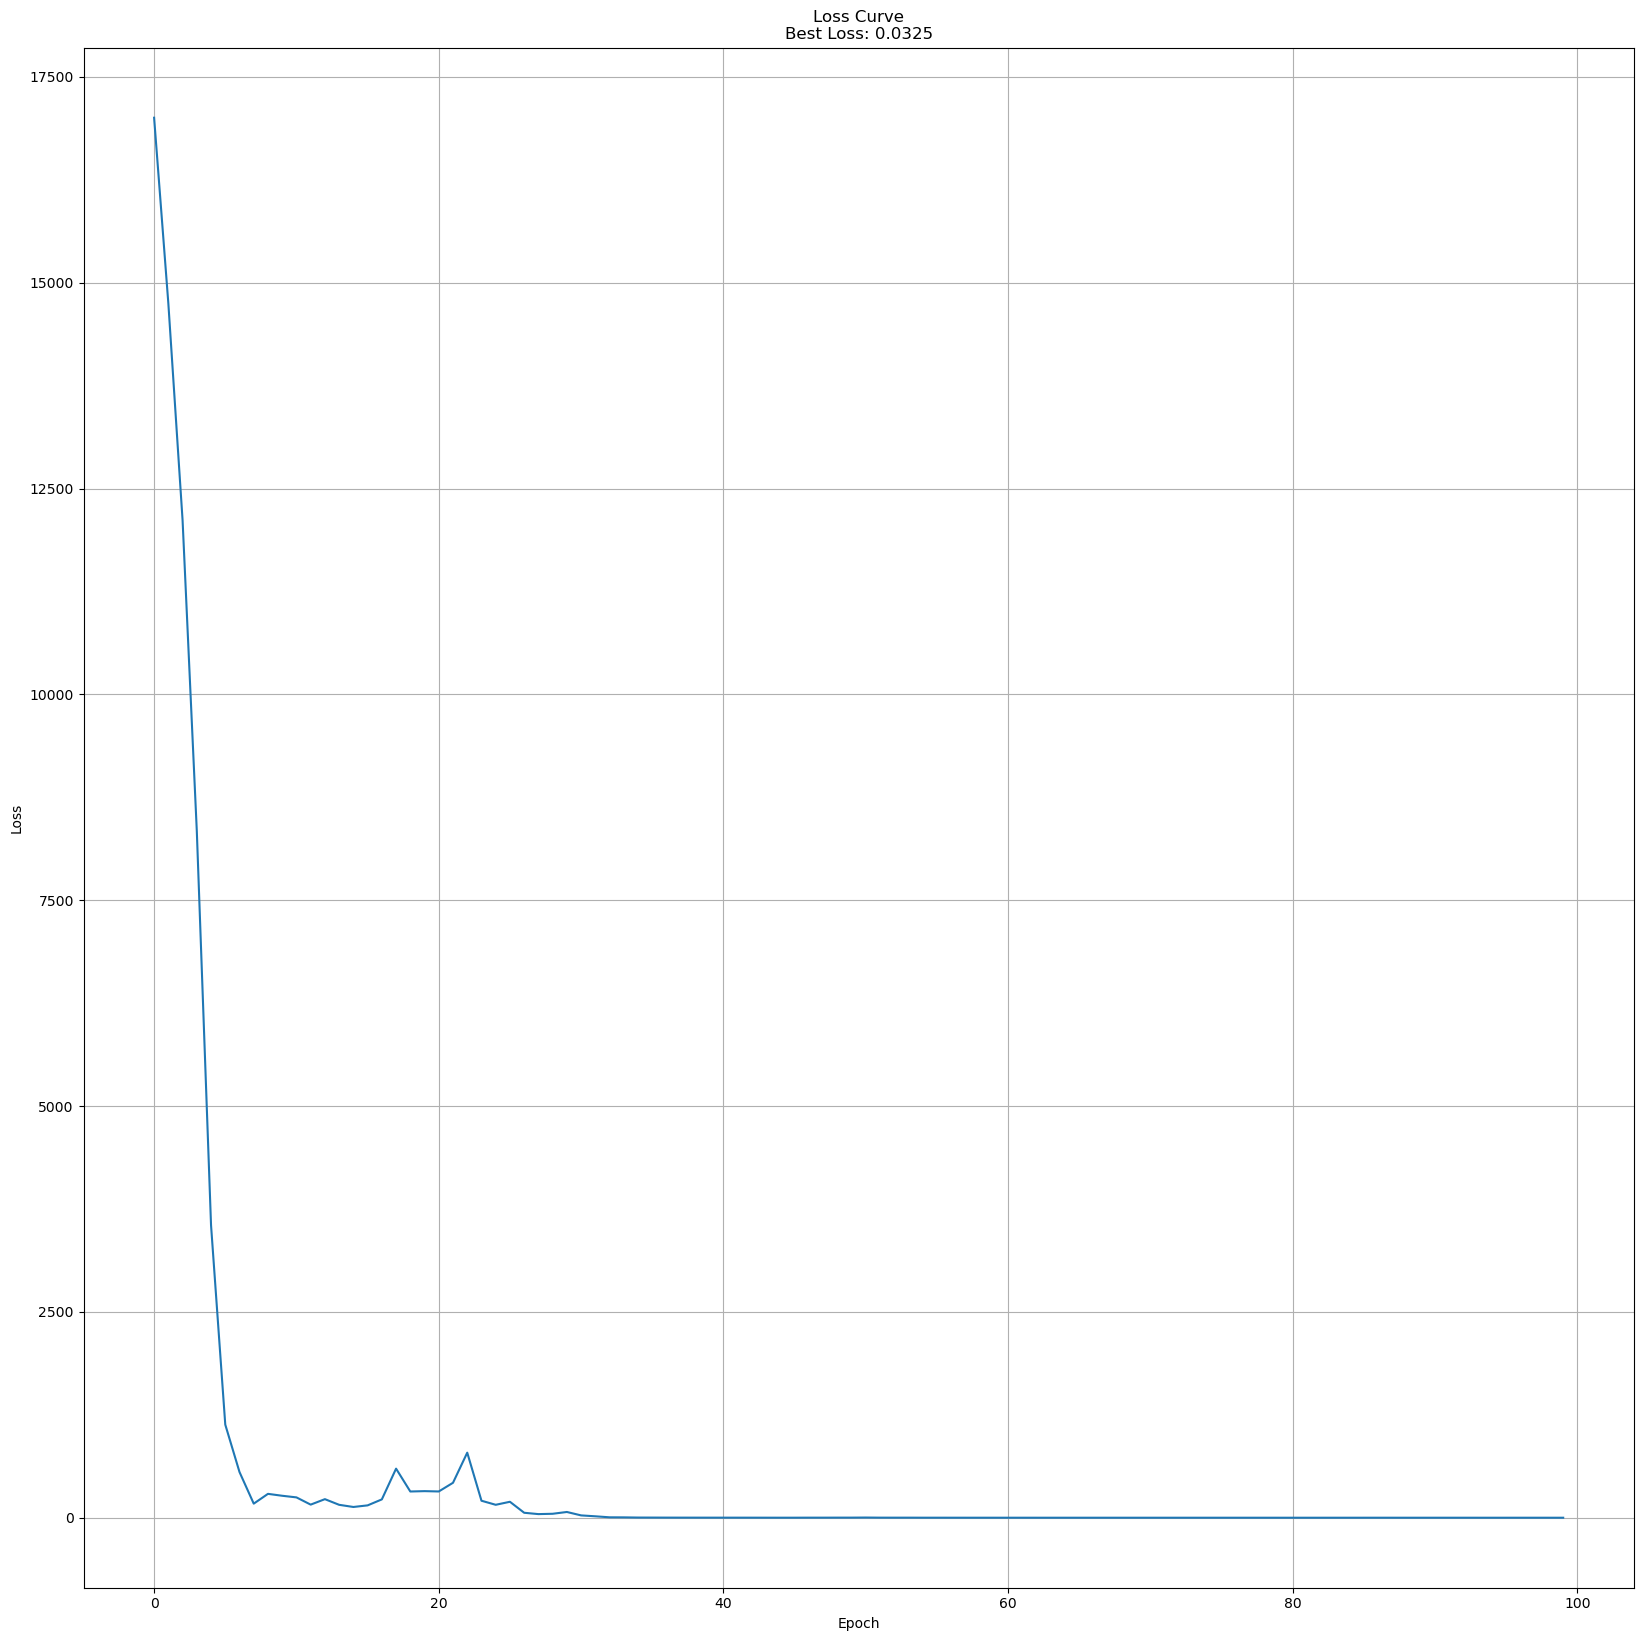

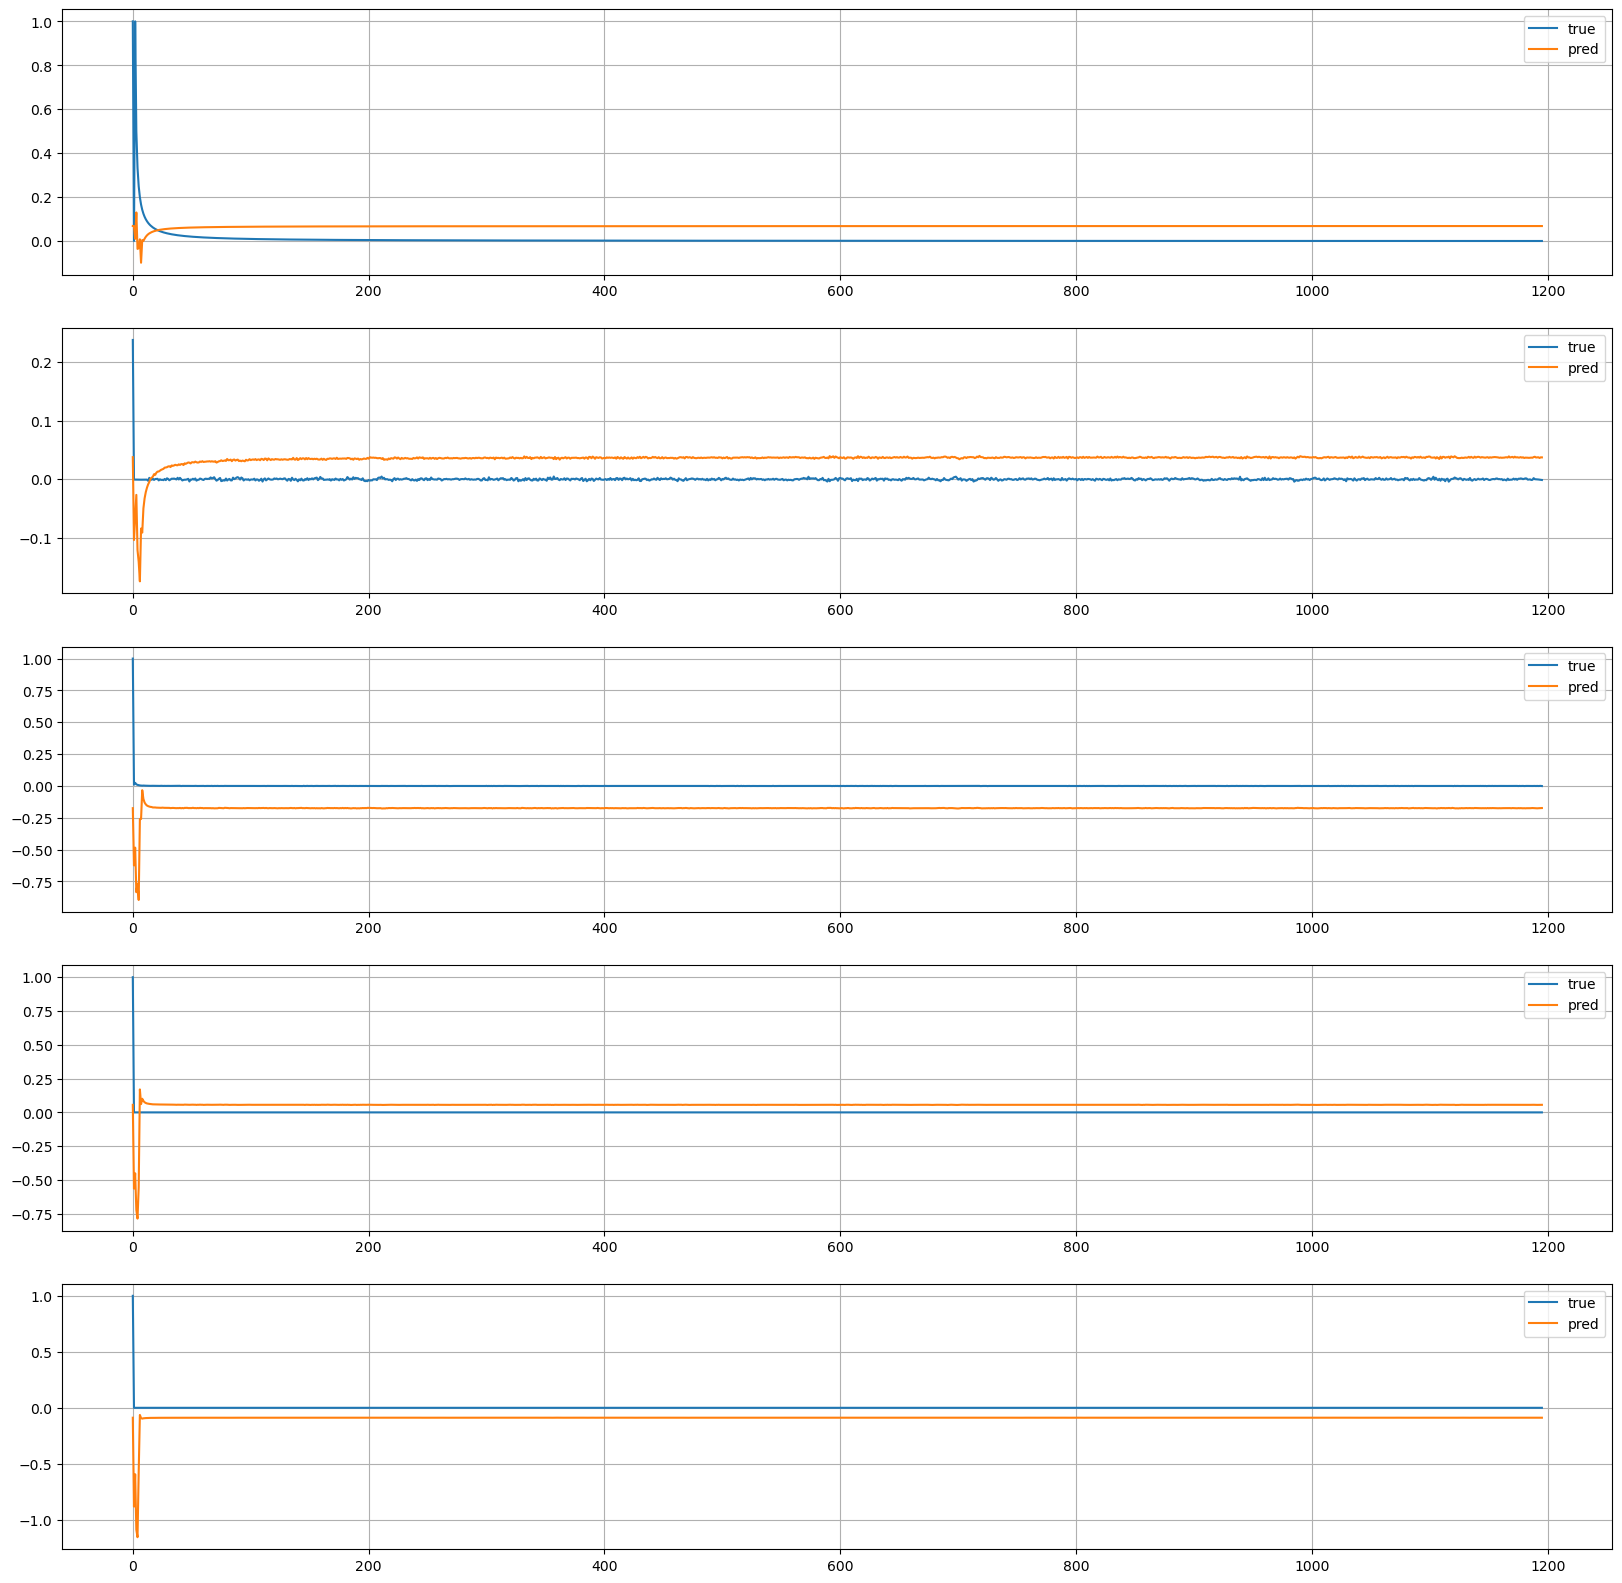

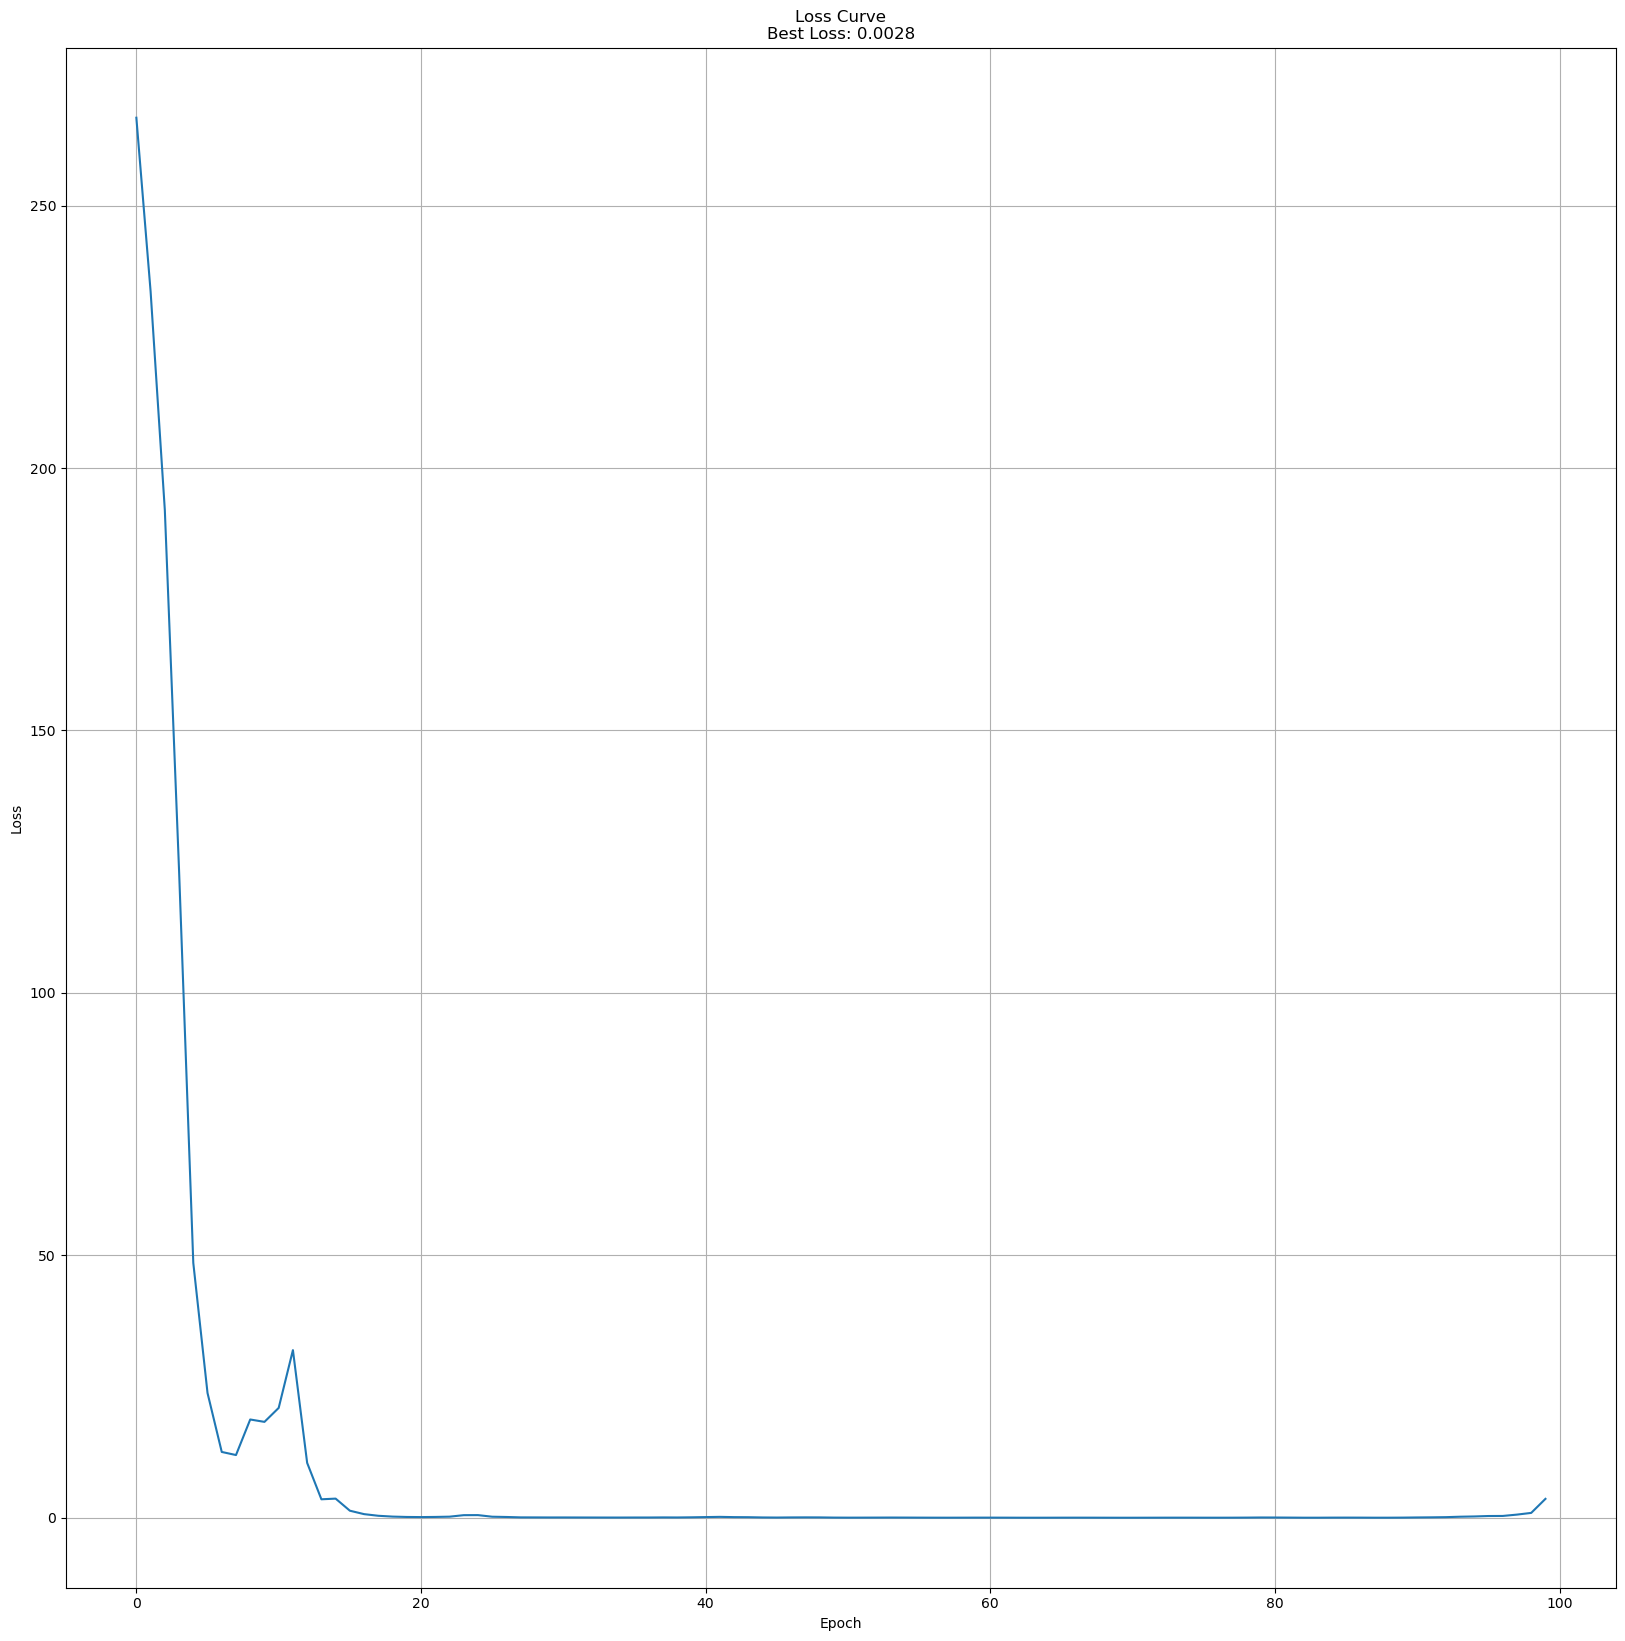

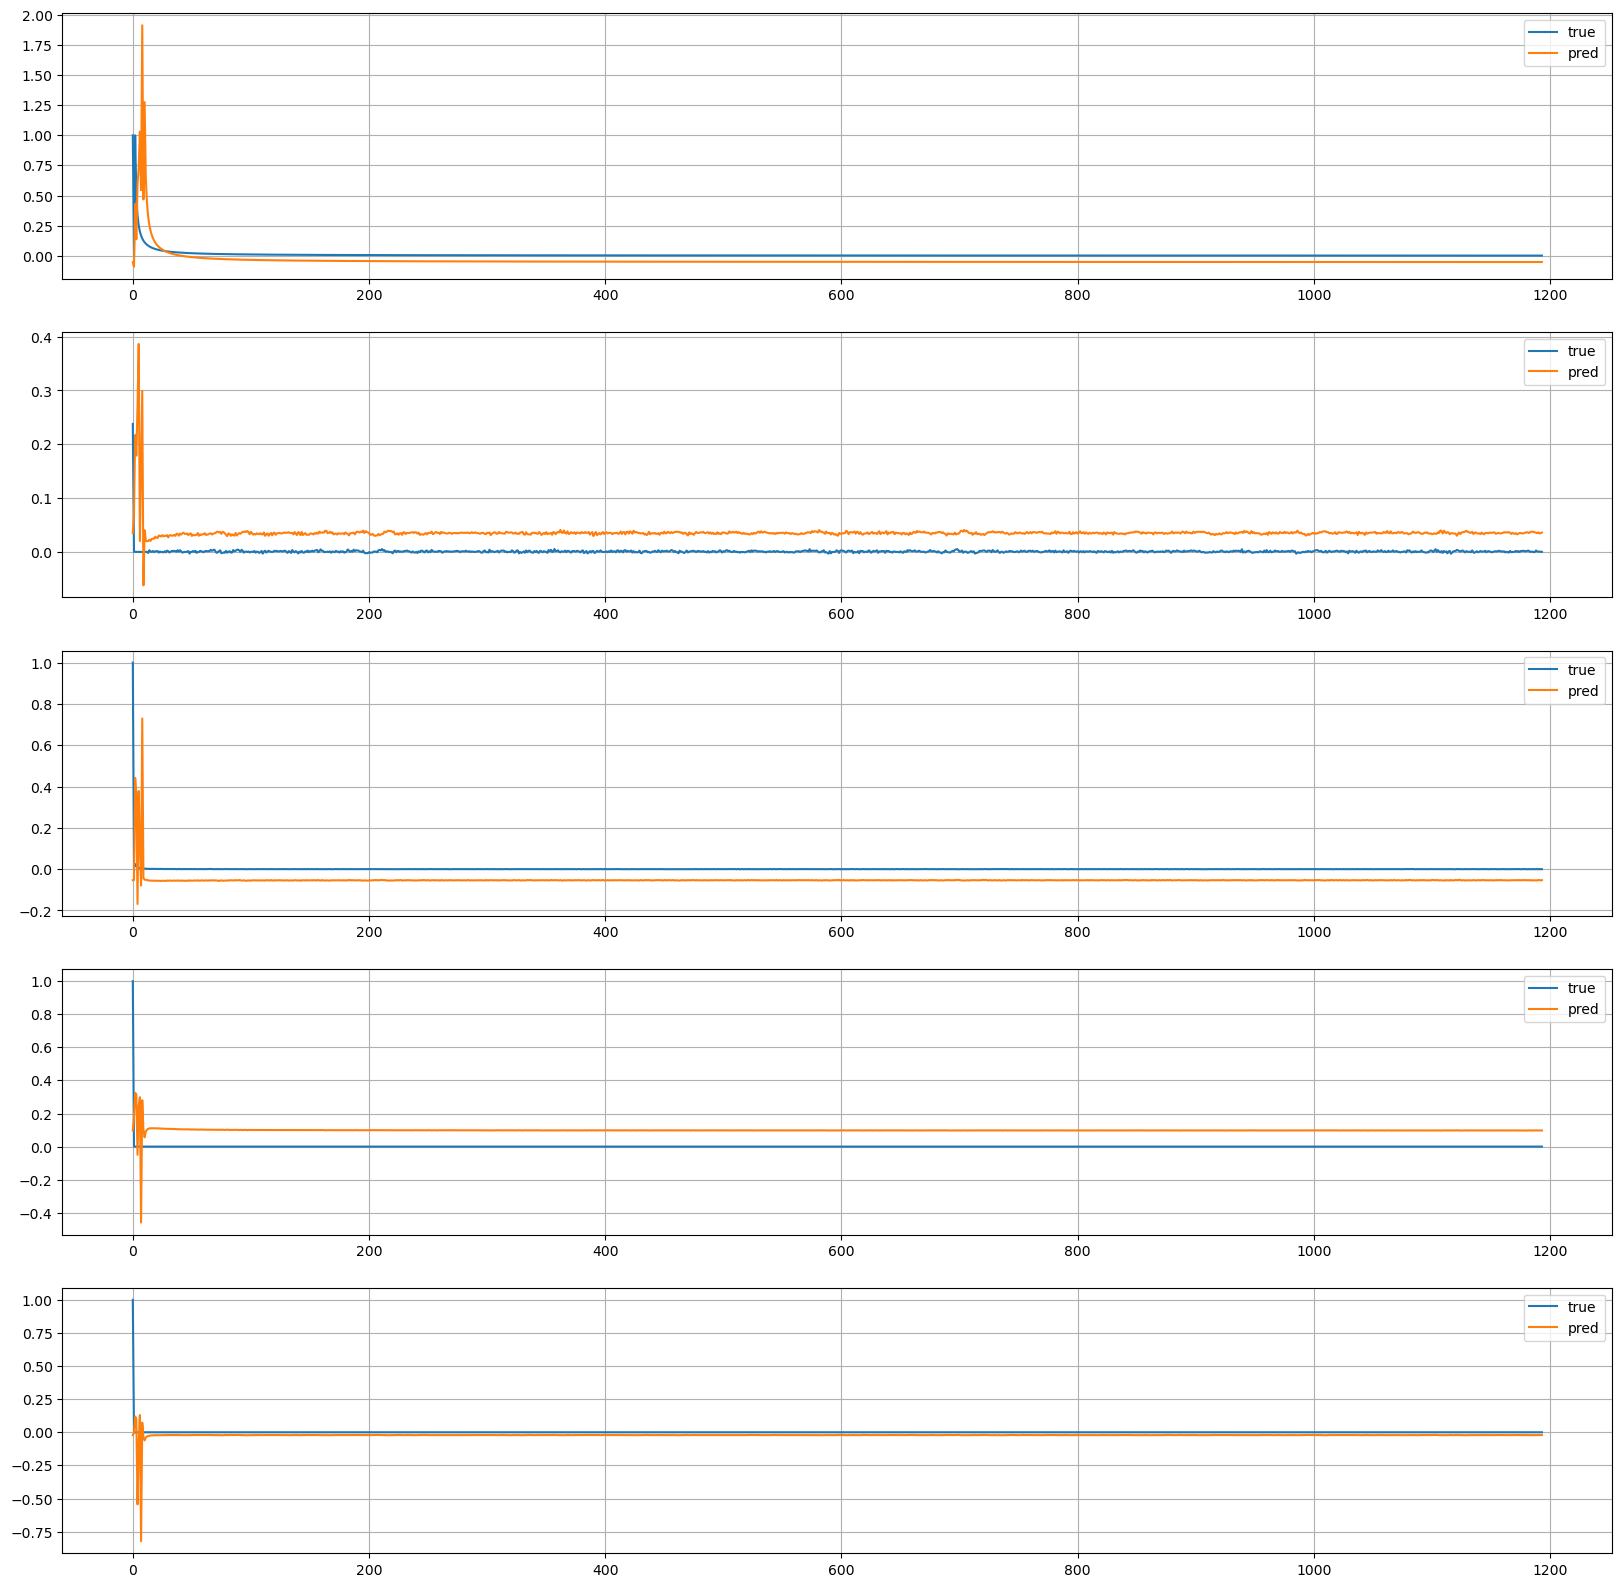

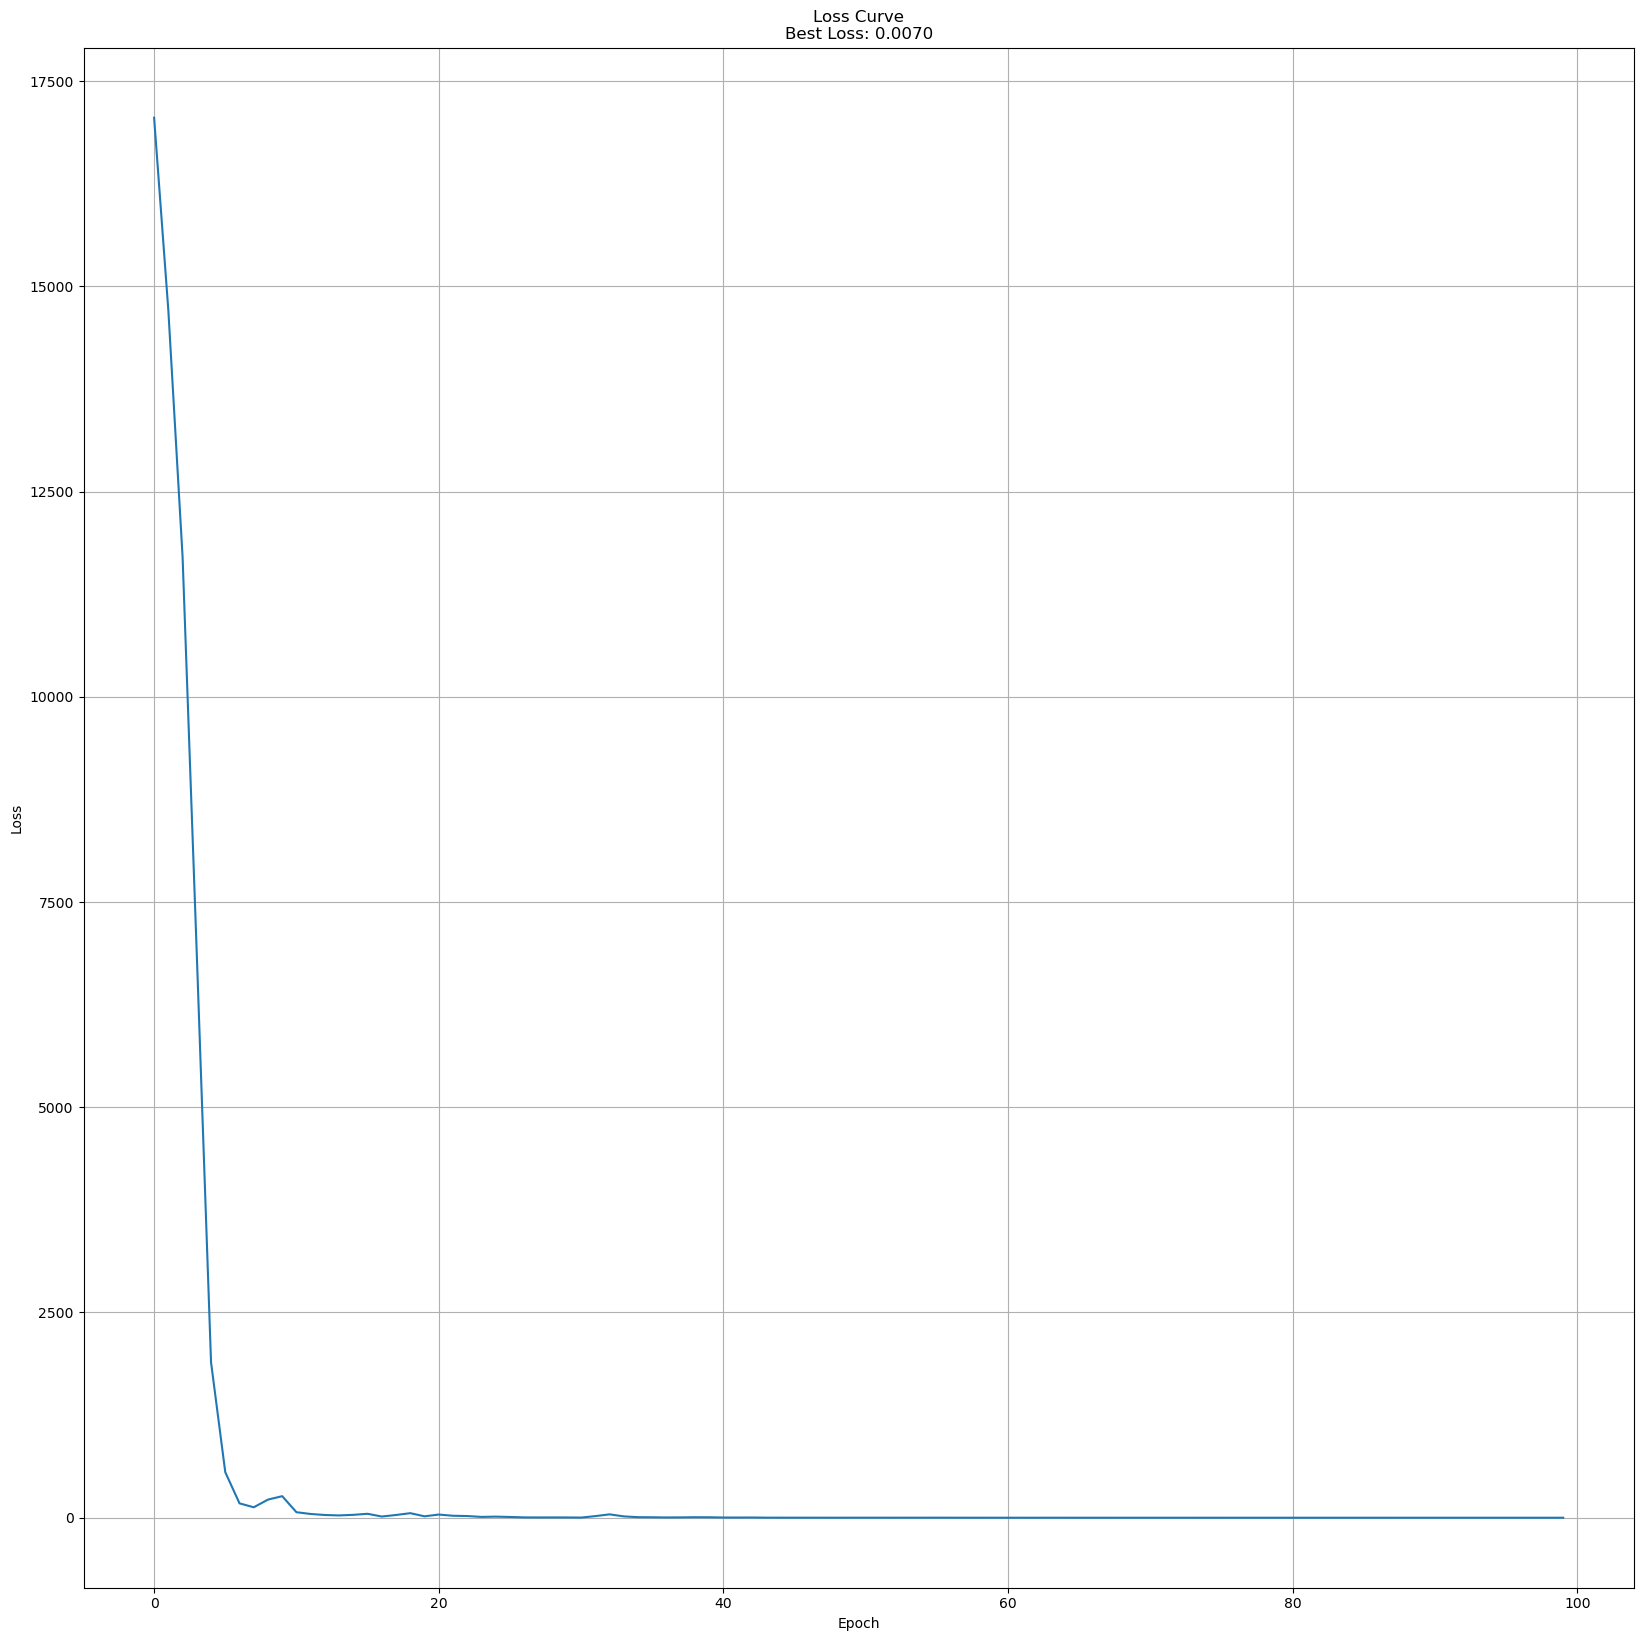

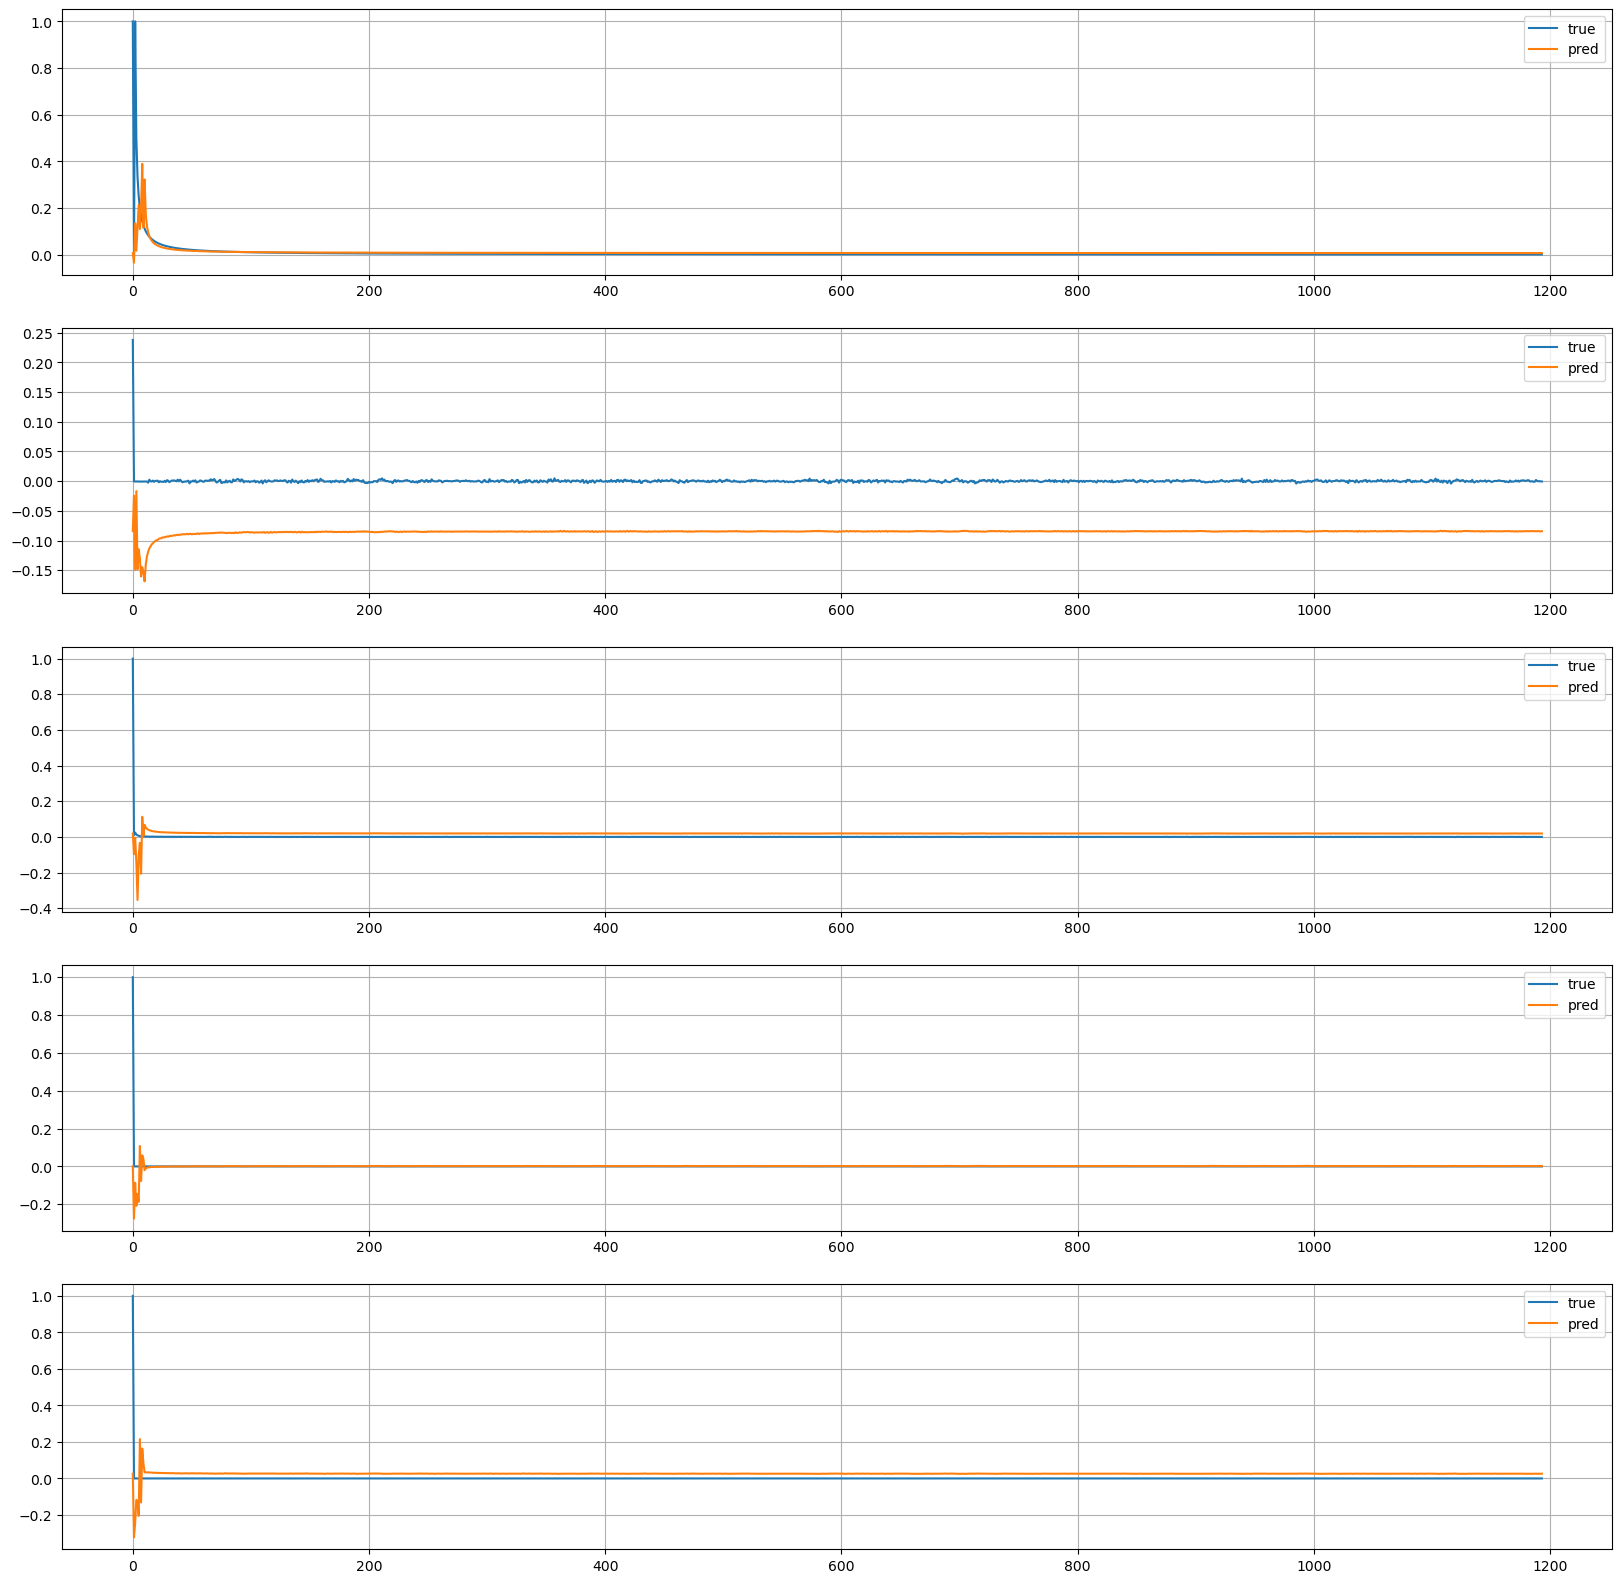

In [33]:
mpg = ParamGrid({
    'd_model': [6,8],
    'n_layers': [12, 96],
})
for params in mpg.grid:
    d = params['d_model']
    l = params['n_layers']
    savedir = f'neuro/models/v5/mamba/d{d}_l{l}_ksmoothed_deltas'
    mmb = MyMamba(MambaConfig(d_model=d, n_layers=l))
    hist = mmb.fit(prepared_data, epochs=100, batch_size=256, savedir=savedir)
    mmb.load_state_dict(torch.load(os.path.join(savedir, 'best.pt'), weights_only=True))
    mmb.test(dataset1[0], contexts[0], savedir=savedir)

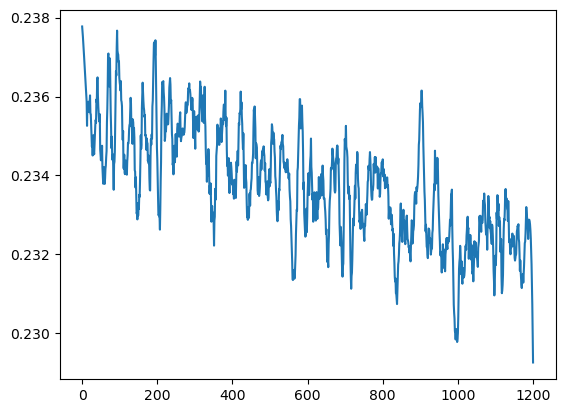

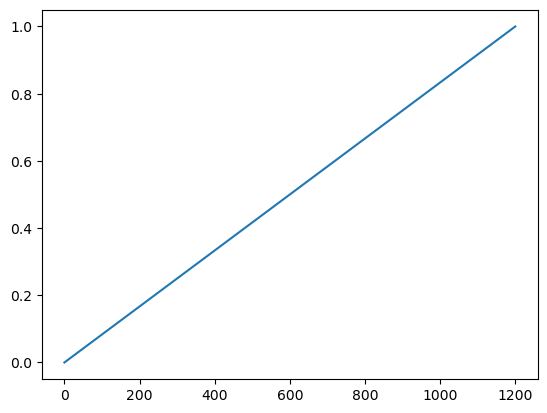

(array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0.00000000e+00, 8.33333333e-04, 1.66666667e-03, 2.50000000e-03,
         3.33333333e-03, 4.16666667e-03, 5.00000000e-03, 5.83333333e-03],
        [2.37775806e-01, 2.37655067e-01, 2.37518550e-01, 2.37368913e-01,
         2.37208810e-01, 2.37040897e-01, 2.36867829e-01, 2.36692263e-01],
        [0.00000000e+00, 9.89177079e-03, 1.01338835e-02, 1.02629398e-02,
         1.03508691e-02, 1.04134117e-02, 1.04568693e-02, 1.04936543e-02],
        [1.00000000e+00, 9.99989231e-01, 9.99978459e-01, 9.99967700e-01,
         9.99956937e-01, 9.99946171e-01, 9.99935411e-01, 9.99924640e-01],
        [1.00000000e+00, 9.99991692e-01, 9.99983394e-01, 9.99975112e-01,
         9.99966696e-01, 9.99958253e-01, 9.99949915e-01, 9.99941592e-01]]))

In [47]:
models_root = 'neuro/models/v5/mamba'
os.listdir(models_root)

['d6_l96_ksmoothed',
 'd6_l12_ksmoothed',
 'd8_l12_ksmoothed',
 'd8_l96_ksmoothed']

In [48]:
ds, ls = [], []
for model in os.listdir(models_root):
    _d, _l, *_ = model.split('_')
    _d = _d.replace('d', '')
    _l = _l.replace('l', '')
    ds.append(int(_d))
    ls.append(int(_l))
ds = list(set(ds))
ls = list(set(ls))
ds.sort()
ls.sort()

([6, 8], [12, 96])

(2, 2)

In [51]:
for i, d in enumerate(ds):
    for j, l in enumerate(ls):
        try:
            res = json.load(open(os.path.join(models_root, f'd{d}_l{l}_ksmoothed/testing_results.json')))
            _mean = res['testing_results']['mean_dif']*100
            _max = res['testing_results']['max_dif']*100
            _max = _max if _max < 100 else 100
            _mean = _mean if _mean < 100 else 100
            maxs[i, j] = _max
            means[i, j] = _mean
        except FileNotFoundError:
            print(f'Testing results for {d} / {l} not found.')

array([[14.03585523, 54.45737839],
       [ 6.19639941,  7.05444366]])

array([[ 87.93595433, 100.        ],
       [100.        ,  27.52364576]])

array([[0, 1],
       [1, 0]])

array([[0, 1],
       [0, 1]])

array([[ True,  True],
       [False, False]])

array([[ True, False],
       [False,  True]])

array([[ True, False],
       [ True, False]])

(array([0, 1]), array([0, 1]))

(array([0, 1]), array([0, 0]))